## Data Exploration

In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

/opt/conda/envs/zhangjx/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.13.0
0.13.0
cpu


In [2]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [3]:
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [4]:
import os
os.listdir('./EMOVO/f1')

['rab-f1-d1.wav',
 'dis-f1-n3.wav',
 'rab-f1-b3.wav',
 'sor-f1-d1.wav',
 'pau-f1-d1.wav',
 'pau-f1-b3.wav',
 'pau-f1-l3.wav',
 'rab-f1-n3.wav',
 'gio-f1-n2.wav',
 'gio-f1-n3.wav',
 'rab-f1-l1.wav',
 'gio-f1-l1.wav',
 'sor-f1-n5.wav',
 'pau-f1-b2.wav',
 'tri-f1-d2.wav',
 'tri-f1-n1.wav',
 'sor-f1-b1.wav',
 'gio-f1-n5.wav',
 'dis-f1-d1.wav',
 'rab-f1-l2.wav',
 'gio-f1-b2.wav',
 'tri-f1-n2.wav',
 'neu-f1-n5.wav',
 'sor-f1-l1.wav',
 'pau-f1-n2.wav',
 'dis-f1-n1.wav',
 'sor-f1-n1.wav',
 'neu-f1-d1.wav',
 'tri-f1-l2.wav',
 'neu-f1-b3.wav',
 'neu-f1-l3.wav',
 'neu-f1-n3.wav',
 'sor-f1-l2.wav',
 'gio-f1-l3.wav',
 'tri-f1-d1.wav',
 'pau-f1-n4.wav',
 'sor-f1-n2.wav',
 'rab-f1-n2.wav',
 'dis-f1-n5.wav',
 'sor-f1-n4.wav',
 'gio-f1-n1.wav',
 'pau-f1-n3.wav',
 'gio-f1-b1.wav',
 'tri-f1-n3.wav',
 'rab-f1-b2.wav',
 'dis-f1-n4.wav',
 'sor-f1-l3.wav',
 'gio-f1-l2.wav',
 'pau-f1-n1.wav',
 'dis-f1-b3.wav',
 'sor-f1-n3.wav',
 'sor-f1-l4.wav',
 'tri-f1-b3.wav',
 'pau-f1-l1.wav',
 'tri-f1-b1.wav',
 'dis-f1-d

In [5]:
sample_file = './EMOVO/f1/dis-f1-n3.wav'
sample_wave, sr = torchaudio.load(sample_file)

In [6]:
sample_wave = sample_wave.to(device)
if sr != bundle.sample_rate:
    sample_wave = torchaudio.functional.resample(sample_wave, sr, bundle.sample_rate)

In [7]:
with torch.inference_mode():
    features, _ = model.extract_features(sample_wave)

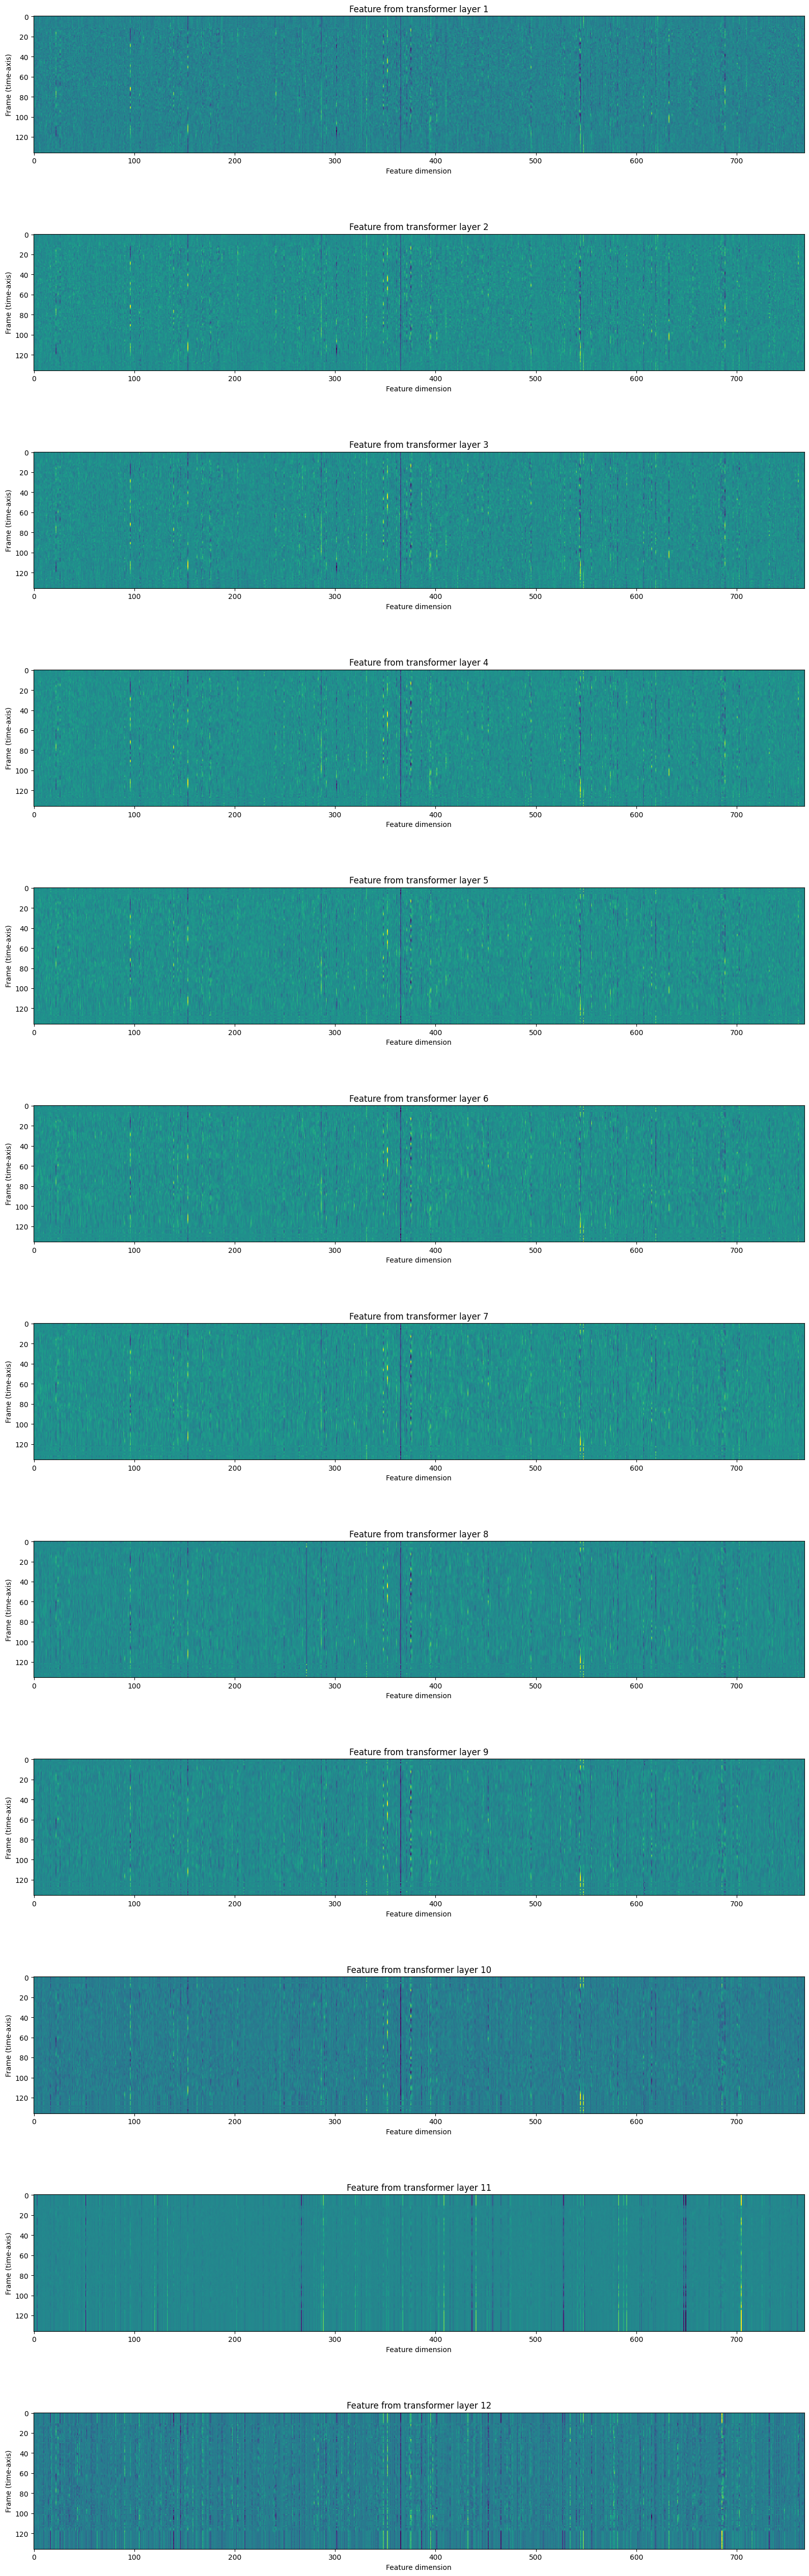

In [8]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

In [9]:
features[0].shape

torch.Size([2, 136, 768])

In [10]:
features[0][0].shape

torch.Size([136, 768])

## Feature Preparation

In [11]:
import os

data_path = './EMOVO/'
folders = ['f1', 'f2', 'f3', 'm1', 'm2', 'm3']
audios = []
labels = []
for folder in folders:
    dir_path = data_path + folder + '/'
    for file in os.listdir(dir_path):
        if 'wav' not in file:
            continue
        file_path = dir_path + file
        label = file.split('-')[0]
        labels.append(label)
        wave, sr = torchaudio.load(file_path)
        wave = wave.to(device)
        if sr != bundle.sample_rate:
            wave = torchaudio.functional.resample(wave, sr, bundle.sample_rate)
        with torch.inference_mode():
            features, _ = model.extract_features(wave)
        audios.append(features[11][0])

In [12]:
audios[0].shape

torch.Size([80, 768])

In [13]:
audios[0].size(0)

80

In [14]:
audios[-1].shape

torch.Size([206, 768])

In [15]:
class MyDataSet(torch.utils.data.Dataset):
    def __init__(self, data, label, label_transform):
        super(MyDataSet).__init__()
        self.data = data
        self.label = label
        self.label_transform = label_transform
        
    def __getitem__(self, idx):
        audio = self.data[idx]
        label = self.label_transform[self.label[idx]]
        length = self.data[idx].size(0)
        return audio, length, label
    
    def __len__(self):
        return len(self.label)

In [16]:
categories = ['dis', 'gio', 'neu', 'pau', 'rab', 'sor', 'tri']
cate_dic = {}
for i, cate in enumerate(categories):
    cate_dic[cate] = i
cate_dic

{'dis': 0, 'gio': 1, 'neu': 2, 'pau': 3, 'rab': 4, 'sor': 5, 'tri': 6}

In [17]:
def collate_indic(data):

    _, lengths, labels = zip(*data)
    max_len = max(lengths)
    n_ftrs = data[0][0].size(1)
    features = torch.zeros((len(data), max_len, n_ftrs))
    labels = torch.tensor(labels)
    lengths = torch.tensor(lengths)

    for i in range(len(data)):
        j, k = data[i][0].size(0), data[i][0].size(1)
        features[i] = torch.cat([data[i][0], torch.zeros((max_len - j, k))])

    return features, lengths, labels

In [18]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

X_train, X_test, y_train, y_test = train_test_split(audios, labels, test_size=0.2, random_state=42)

train_dataset = MyDataSet(X_train, y_train, cate_dic)
trainloader_args = dict(batch_size=64, shuffle=True)
train_dataloader = DataLoader(train_dataset, **trainloader_args, collate_fn=collate_indic)

test_dataset = MyDataSet(X_test, y_test, cate_dic)
testloader_args = dict(batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, **testloader_args, collate_fn=collate_indic)

In [19]:
for batch, data in enumerate(train_dataloader):
    x, length, y = data
    print(batch, x.shape)

0 torch.Size([64, 450, 768])
1 torch.Size([64, 610, 768])
2 torch.Size([64, 317, 768])
3 torch.Size([64, 380, 768])
4 torch.Size([64, 517, 768])
5 torch.Size([64, 308, 768])
6 torch.Size([64, 699, 768])
7 torch.Size([22, 353, 768])


## CNN

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class ICASSP2CNN(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=512, num_lstm_layers = 2, bidirectional = False, label_size=7):
        super().__init__()
        self.n_layers = num_lstm_layers 
        self.hidden = hidden_size
        self.bidirectional = bidirectional
        
        self.embed = nn.Linear(in_features = vocab_size, out_features = embed_size)

        self.cnn  = nn.Conv1d(embed_size, embed_size, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(embed_size, embed_size, kernel_size=5, padding=2)

        self.batchnorm = nn.BatchNorm1d(2 * embed_size)

        self.lstm = nn.LSTM(input_size = 2 * embed_size, 
                            hidden_size = hidden_size, 
                            num_layers = num_lstm_layers, 
                            bidirectional = bidirectional)

        self.linear = nn.Linear(in_features = 2 * hidden_size if bidirectional else hidden_size, 
                                out_features = label_size)


    def forward(self, x, lengths):
        """
        padded_x: (B,T) padded LongTensor
        """

        input = self.embed(x)

        batch_size = input.size(0)
        input = input.transpose(1,2)    # (B,T,H) -> (B,H,T)

        cnn_output = torch.cat([self.cnn(input), self.cnn2(input)], dim=1)

        input = F.relu(self.batchnorm(cnn_output))

        input = input.transpose(1,2)

        pack_tensor = nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=True, enforce_sorted=False)
        _, (hn, cn) = self.lstm(pack_tensor)

        if self.bidirectional:
            h_n = hn.view(self.n_layers, 2, batch_size, self.hidden)
            h_n = torch.cat([ h_n[-1, 0,:], h_n[-1,1,:] ], dim = 1)
        else:
            h_n = hn[-1]

        logits = self.linear(h_n)

        return logits

In [21]:
from torchsummary import summary

model = ICASSP2CNN(768)

In [24]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [25]:
from tqdm import tqdm

loss_accum = 0.0
batch_cnt = 0

acc_cnt = 0     #count correct predictions
err_cnt = 0     #count incorrect predictions

model.train()
for epoch in tqdm(range(50)):
    for batch, (x, length, y) in enumerate(train_dataloader):
        x = x.to(device)
        #lengths = lengths.to(device)
        y = y.to(device)
        optimizer.zero_grad()

        logits = model(x, length)

        loss = criterion(logits, y)
        loss_score = loss.cpu().item()

        loss_accum += loss_score
        batch_cnt += 1
        loss.backward()
        optimizer.step()

        #model outputs
        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1

    training_accuracy =  acc_cnt/(err_cnt+acc_cnt) 
    training_loss = loss_accum / batch_cnt
    print(f"epoch:{epoch}, accuracy:{training_accuracy}, loss:{training_loss}")

  2%|███▎                                                                                                                                                                 | 1/50 [07:38<6:14:04, 458.05s/it]

epoch:0, accuracy:0.14042553191489363, loss:2.08977372944355


  4%|██████▌                                                                                                                                                              | 2/50 [14:37<5:48:10, 435.21s/it]

epoch:1, accuracy:0.1351063829787234, loss:2.0267335325479507


  6%|█████████▉                                                                                                                                                           | 3/50 [22:15<5:49:07, 445.70s/it]

epoch:2, accuracy:0.15319148936170213, loss:1.9907939583063126


  8%|█████████████▏                                                                                                                                                       | 4/50 [28:38<5:22:52, 421.15s/it]

epoch:3, accuracy:0.16648936170212766, loss:1.962712723761797


 10%|████████████████▌                                                                                                                                                    | 5/50 [34:32<4:57:41, 396.92s/it]

epoch:4, accuracy:0.1774468085106383, loss:1.9422408640384674


 12%|███████████████████▊                                                                                                                                                 | 6/50 [40:44<4:44:52, 388.47s/it]

epoch:5, accuracy:0.18333333333333332, loss:1.9263842677076657


 14%|███████████████████████                                                                                                                                              | 7/50 [46:41<4:30:59, 378.12s/it]

epoch:6, accuracy:0.18723404255319148, loss:1.9172740067754472


 16%|██████████████████████████▍                                                                                                                                          | 8/50 [52:35<4:19:11, 370.28s/it]

epoch:7, accuracy:0.19175531914893618, loss:1.9057248029857874


 18%|█████████████████████████████▋                                                                                                                                       | 9/50 [58:32<4:10:14, 366.20s/it]

epoch:8, accuracy:0.19527186761229315, loss:1.8958359244796965


 20%|████████████████████████████████▍                                                                                                                                 | 10/50 [1:04:26<4:01:39, 362.50s/it]

epoch:9, accuracy:0.19680851063829788, loss:1.8917628198862075


 22%|███████████████████████████████████▋                                                                                                                              | 11/50 [1:10:27<3:55:12, 361.87s/it]

epoch:10, accuracy:0.1988394584139265, loss:1.8886988461017609


 24%|██████████████████████████████████████▉                                                                                                                           | 12/50 [1:16:31<3:49:41, 362.66s/it]

epoch:11, accuracy:0.20106382978723406, loss:1.8836842142045498


 26%|██████████████████████████████████████████                                                                                                                        | 13/50 [1:22:32<3:43:14, 362.01s/it]

epoch:12, accuracy:0.2037643207855974, loss:1.8770888550923421


 28%|█████████████████████████████████████████████▎                                                                                                                    | 14/50 [1:29:05<3:42:55, 371.55s/it]

epoch:13, accuracy:0.20699088145896657, loss:1.871756796325956


 30%|████████████████████████████████████████████████▌                                                                                                                 | 15/50 [1:34:46<3:31:20, 362.29s/it]

epoch:14, accuracy:0.20907801418439717, loss:1.865275760491689


 32%|███████████████████████████████████████████████████▊                                                                                                              | 16/50 [1:41:15<3:29:54, 370.41s/it]

epoch:15, accuracy:0.21170212765957447, loss:1.8592417566105723


 34%|███████████████████████████████████████████████████████                                                                                                           | 17/50 [1:47:43<3:26:35, 375.63s/it]

epoch:16, accuracy:0.2146433041301627, loss:1.8526361207751667


 36%|██████████████████████████████████████████████████████████▎                                                                                                       | 18/50 [1:53:34<3:16:21, 368.17s/it]

epoch:17, accuracy:0.2190307328605201, loss:1.847035214304924


 38%|█████████████████████████████████████████████████████████████▌                                                                                                    | 19/50 [1:59:20<3:06:51, 361.66s/it]

epoch:18, accuracy:0.22049272116461366, loss:1.8448037818858498


 40%|████████████████████████████████████████████████████████████████▊                                                                                                 | 20/50 [2:05:35<3:02:50, 365.68s/it]

epoch:19, accuracy:0.2226595744680851, loss:1.8415228687226772


 42%|████████████████████████████████████████████████████████████████████                                                                                              | 21/50 [2:11:22<2:54:01, 360.07s/it]

epoch:20, accuracy:0.22532928064842958, loss:1.8347427923054922


 44%|███████████████████████████████████████████████████████████████████████▎                                                                                          | 22/50 [2:17:25<2:48:20, 360.74s/it]

epoch:21, accuracy:0.22911025145067698, loss:1.8291656842285937


 46%|██████████████████████████████████████████████████████████████████████████▌                                                                                       | 23/50 [2:23:14<2:40:50, 357.43s/it]

epoch:22, accuracy:0.23237742830712305, loss:1.8245111379934393


 48%|█████████████████████████████████████████████████████████████████████████████▊                                                                                    | 24/50 [2:29:29<2:37:05, 362.52s/it]

epoch:23, accuracy:0.2346631205673759, loss:1.8208904719601076


 50%|█████████████████████████████████████████████████████████████████████████████████                                                                                 | 25/50 [2:35:23<2:29:58, 359.93s/it]

epoch:24, accuracy:0.23702127659574468, loss:1.8163799858093261


 52%|████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 26/50 [2:40:51<2:20:10, 350.42s/it]

epoch:25, accuracy:0.23895253682487724, loss:1.8134870156645775


 54%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 27/50 [2:46:17<2:11:29, 343.04s/it]

epoch:26, accuracy:0.2408983451536643, loss:1.80991935674791


 56%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 28/50 [2:52:19<2:07:56, 348.92s/it]

epoch:27, accuracy:0.24278115501519756, loss:1.807501567793744


 58%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 29/50 [2:58:06<2:01:54, 348.33s/it]

epoch:28, accuracy:0.2442406456346295, loss:1.8041511825446426


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 30/50 [3:04:10<1:57:40, 353.04s/it]

epoch:29, accuracy:0.24673758865248227, loss:1.7986505980292955


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 31/50 [3:09:53<1:50:47, 349.89s/it]

epoch:30, accuracy:0.24955387783115993, loss:1.794294132340339


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 32/50 [3:15:26<1:43:25, 344.75s/it]

epoch:31, accuracy:0.2524601063829787, loss:1.7877151467837393


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 33/50 [3:21:27<1:39:06, 349.79s/it]

epoch:32, accuracy:0.25538362346872984, loss:1.7828688942121738


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 34/50 [3:27:41<1:35:12, 357.00s/it]

epoch:33, accuracy:0.2575719649561952, loss:1.7780634471598793


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 35/50 [3:33:46<1:29:49, 359.32s/it]

epoch:34, accuracy:0.25933130699088147, loss:1.7735208975417274


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 36/50 [3:39:27<1:22:32, 353.75s/it]

epoch:35, accuracy:0.26170212765957446, loss:1.7693302945958242


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 37/50 [3:45:39<1:17:51, 359.32s/it]

epoch:36, accuracy:0.2640598044853364, loss:1.7649713597587637


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 38/50 [3:51:21<1:10:51, 354.25s/it]

epoch:37, accuracy:0.2667413213885778, loss:1.7606435402443534


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 39/50 [3:57:18<1:05:05, 355.09s/it]

epoch:38, accuracy:0.26988543371522095, loss:1.755413524233378


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 40/50 [4:03:14<59:13, 355.32s/it]

epoch:39, accuracy:0.27106382978723403, loss:1.7542822908610105


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 41/50 [4:09:02<52:58, 353.15s/it]

epoch:40, accuracy:0.2723923196678775, loss:1.7521523386240005


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 42/50 [4:14:46<46:42, 350.34s/it]

epoch:41, accuracy:0.27477203647416415, loss:1.7490906867952574


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 43/50 [4:20:58<41:38, 356.94s/it]

epoch:42, accuracy:0.27704106877783274, loss:1.744380571467932


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 44/50 [4:26:45<35:22, 353.81s/it]

epoch:43, accuracy:0.27988394584139265, loss:1.7392952428622679


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 45/50 [4:33:01<30:02, 360.54s/it]

epoch:44, accuracy:0.2825531914893617, loss:1.7340356919500564


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 46/50 [4:38:54<23:53, 358.29s/it]

epoch:45, accuracy:0.2845513413506013, loss:1.7296401582982228


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 47/50 [4:44:54<17:56, 358.69s/it]

epoch:46, accuracy:0.2867360796740607, loss:1.7249586499751883


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 48/50 [4:50:42<11:50, 355.44s/it]

epoch:47, accuracy:0.28976063829787235, loss:1.719407823557655


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 49/50 [4:56:58<06:01, 361.78s/it]

epoch:48, accuracy:0.29274858879722104, loss:1.713440083119334


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [5:02:39<00:00, 363.20s/it]

epoch:49, accuracy:0.2943404255319149, loss:1.7102845433354377
